In [2]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
import numpy as np
import geopandas as gpd 
import pandas as pd
import osmnx
import contextily as cx 
import matplotlib.pyplot as plt 
from pyproj import CRS
import seaborn as sns
import numpy as np
from dateutil.parser import parse

import helper

In [3]:
def createstationdf (df):
    # Create unique dataframes for start and end stations
    start_stations = df[['start_station_id', 'start_station_name', 'start_station_description', 'start_station_latitude', 'start_station_longitude', 'month', 'year']].drop_duplicates()
    end_stations = df[['end_station_id', 'end_station_name', 'end_station_description', 'end_station_latitude', 'end_station_longitude', 'month', 'year']].drop_duplicates()
    
    # Rename columns for uniformity
    start_stations.columns = ['station_id', 'station_name', 'station_description', 'latitude', 'longitude', 'month', 'year']
    end_stations.columns = ['station_id', 'station_name', 'station_description', 'latitude', 'longitude', 'month', 'year']
    
    # Concatenate the dataframes
    stations = pd.concat([start_stations, end_stations]).drop_duplicates()
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude), crs = 4326
    )
    return gdf_stations

In [4]:
df = pd.read_csv('data/preprocessed/combined.csv')
station_df = createstationdf(df)

In [5]:
station_df.head(5)

,station_id,station_name,station_description,latitude,longitude,month,year,geometry
0,507,Jens Bjelkes Gate,ved Trondheimsveien,59.919147,10.764130,10,23,POINT (10.76413 59.91915)
1,607,Marcus Thranes gate,ved Akerselva,59.932772,10.758595,10,23,POINT (10.75859 59.93277)
2,500,Anker Hotel,langs Storgata,59.917279,10.758155,10,23,POINT (10.75816 59.91728)
3,599,Paléhaven,langs Strandgata,59.910331,10.750110,10,23,POINT (10.75011 59.91033)
4,597,Fredensborg,ved rundkjøringen,59.920995,10.750358,10,23,POINT (10.75036 59.92099)


EPSG:3857


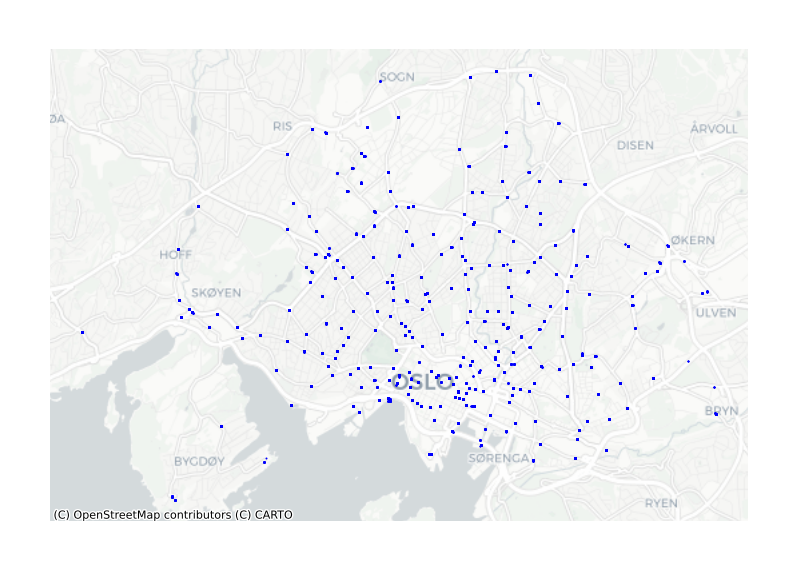

In [6]:
# Transform to an equal area projection
station_df_equal_area = station_df.to_crs(epsg=3857)
print(station_df_equal_area.crs)

ax = station_df_equal_area.plot(color='blue', figsize=(9, 9), markersize=2)
cx.add_basemap(ax, crs=station_df_equal_area.crs, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_aspect('equal')

In [7]:
# Load the GeoJSON file
oslo_kommuner_gdf = gpd.read_file('data/Oslo_Kommuner.geojson')
# Set the correct CRS
oslo_kommuner_gdf.set_crs('EPSG:32633', inplace=True, allow_override=True)

# Now you can convert to EPSG:3857
oslo_kommuner_gdf = oslo_kommuner_gdf.to_crs(epsg=3857)
oslo_kommuner_gdf

,bydelnavn,bydelnr,geometry
0,Frogner,030105,"MULTIPOLYGON (((1189421.693 8375826.292, 11864..."
1,Østensjø,030113,"MULTIPOLYGON (((1206718.020 8369118.365, 12067..."
2,Søndre Nordstrand,030115,"MULTIPOLYGON (((1210120.108 8358267.151, 12100..."
3,Marka,030117,"MULTIPOLYGON (((1214365.526 8369957.278, 12144..."
4,Sentrum,030116,"MULTIPOLYGON (((1196018.635 8377365.629, 11942..."
5,Alna,030112,"MULTIPOLYGON (((1205215.968 8380229.102, 12052..."
6,Bjerke,030109,"MULTIPOLYGON (((1203016.469 8382862.767, 12030..."
7,Stovner,030111,"MULTIPOLYGON (((1218089.544 8387654.266, 12180..."
8,Sagene,030103,"MULTIPOLYGON (((1199084.696 8384380.160, 11990..."
9,Nordre Aker,030108,"MULTIPOLYGON (((1201030.109 8386195.948, 12009..."


/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


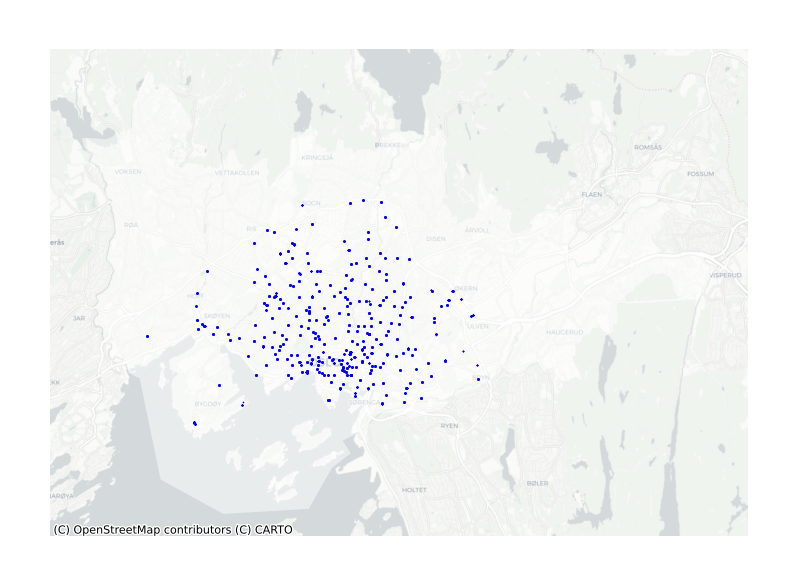

In [8]:
from geopandas.tools import sjoin

# Transform oslo_kommuner_gdf to an equal area projection
oslo_kommuner_gdf_equal_area = oslo_kommuner_gdf.to_crs(epsg=3857)

# Transform station_df to an equal area projection
station_df_equal_area = station_df.to_crs(epsg=3857)

# Add an index column
oslo_kommuner_gdf_equal_area['index'] = oslo_kommuner_gdf_equal_area.index

# Perform a spatial join between the polygons and the stations
joined = sjoin(oslo_kommuner_gdf_equal_area, station_df_equal_area, how='inner', op='contains')

# Remove duplicate polygons
unique_polygons = joined.drop_duplicates(subset='index')

# Plot the unique polygons with stations
ax = unique_polygons.plot(color='white', edgecolor='black', alpha=0.5, figsize=(9, 9))

# Add the station_df
station_df_equal_area.plot(ax=ax, color='blue', markersize=1.5)

# Add a basemap
cx.add_basemap(ax, crs=station_df_equal_area.crs, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.set_aspect('equal')

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


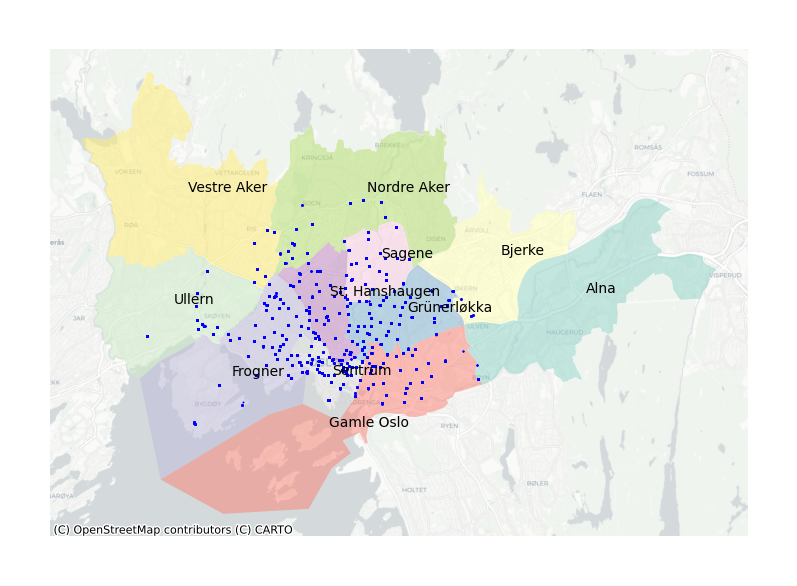

In [9]:
from geopandas.tools import sjoin

# Transform oslo_kommuner_gdf to an equal area projection
oslo_kommuner_gdf_equal_area = oslo_kommuner_gdf.to_crs(epsg=3857)

# Transform station_df to an equal area projection
station_df_equal_area = station_df.to_crs(epsg=3857)

# Add an index column
oslo_kommuner_gdf_equal_area['index'] = oslo_kommuner_gdf_equal_area.index

# Perform a spatial join between the polygons and the stations
joined = sjoin(oslo_kommuner_gdf_equal_area, station_df_equal_area, how='inner', op='contains')

# Remove duplicate polygons
unique_polygons = joined.drop_duplicates(subset='index')

# Plot the unique polygons with stations, with a different color for each district
ax = unique_polygons.plot(column='bydelnavn', cmap='Set3', alpha=0.5, figsize=(9, 9))

# Add the station_df
station_df_equal_area.plot(ax=ax, color='blue', markersize=2)

# Add a basemap
cx.add_basemap(ax, crs=station_df_equal_area.crs, source=cx.providers.CartoDB.Positron)

# Add the name of each district
for x, y, label in zip(unique_polygons.geometry.centroid.x, unique_polygons.geometry.centroid.y, unique_polygons['bydelnavn']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_axis_off()
ax.set_aspect('equal')

In [10]:
df = pd.read_csv('data/monthly/24_03.csv')
gdf_rides = helper.create_rides_gdf(df)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/helper.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


In [11]:
from geopandas.tools import sjoin

# Perform a spatial join between the stations and the districts
joined = sjoin(station_df_equal_area, oslo_kommuner_gdf_equal_area, how='left', op='within')

# The 'district' column in 'joined' now contains the district of each station
station_df_equal_area['district'] = joined['bydelnavn']
station_df_equal_area.head(5)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,station_id,station_name,station_description,latitude,longitude,month,year,geometry,district
0,507,Jens Bjelkes Gate,ved Trondheimsveien,59.919147,10.764130,10,23,POINT (1198257.424 8381758.913),Grünerløkka
1,607,Marcus Thranes gate,ved Akerselva,59.932772,10.758595,10,23,POINT (1197641.308 8384785.559),Sagene
2,500,Anker Hotel,langs Storgata,59.917279,10.758155,10,23,POINT (1197592.370 8381344.042),Grünerløkka
3,599,Paléhaven,langs Strandgata,59.910331,10.750110,10,23,POINT (1196696.771 8379801.076),Sentrum
4,597,Fredensborg,ved rundkjøringen,59.920995,10.750358,10,23,POINT (1196724.378 8382169.263),St. Hanshaugen


In [12]:
gdf_rides.head(5)
gdf_rides.shape

(22254, 14)

In [13]:
# Create a dictionary from unique_polygons DataFrame
district_dict = station_df_equal_area.set_index('station_id')['district'].to_dict()

# Use the map function on the start_station_id and end_station_id columns
gdf_rides['start_district'] = gdf_rides['start_station_id'].map(district_dict)
gdf_rides['end_district'] = gdf_rides['end_station_id'].map(district_dict)
district_dict

{507: 'Grünerløkka',
 607: 'Sagene',
 500: 'Grünerløkka',
 599: 'Sentrum',
 597: 'St. Hanshaugen',
 598: 'Grünerløkka',
 522: 'Gamle Oslo',
 407: 'Sagene',
 404: 'Frogner',
 617: 'St. Hanshaugen',
 401: 'Grünerløkka',
 2305: 'Grünerløkka',
 525: 'Sagene',
 384: 'St. Hanshaugen',
 440: 'Gamle Oslo',
 2304: 'Gamle Oslo',
 424: 'Grünerløkka',
 412: 'Grünerløkka',
 472: 'Sagene',
 446: 'St. Hanshaugen',
 470: 'St. Hanshaugen',
 383: 'St. Hanshaugen',
 410: 'Sagene',
 548: 'Frogner',
 2358: 'Frogner',
 2308: 'St. Hanshaugen',
 564: 'Frogner',
 2351: 'Nordre Aker',
 578: 'St. Hanshaugen',
 461: 'Gamle Oslo',
 624: 'Grünerløkka',
 499: 'St. Hanshaugen',
 511: 'Frogner',
 398: 'Sagene',
 462: 'St. Hanshaugen',
 480: 'Gamle Oslo',
 423: 'Grünerløkka',
 540: 'Sagene',
 506: 'Grünerløkka',
 382: 'St. Hanshaugen',
 568: 'Frogner',
 626: 'Frogner',
 485: 'Gamle Oslo',
 388: 'Frogner',
 738: 'Gamle Oslo',
 421: 'Grünerløkka',
 535: 'Frogner',
 3725: 'St. Hanshaugen',
 542: 'Grünerløkka',
 563: 'Frog

In [14]:
sample_rides = gdf_rides.sample(1000)
gdf_rides.head(5)

,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,end_station_description,end_station_latitude,end_station_longitude,geometry,start_district,end_district
0,615,452,2024-03-01 04:34:34.497000+00:00,2024-03-01 04:39:41.953000+00:00,307,Munkedamsveien,ved Haakon VIIs gate,59.913523,10.730106,Vippetangen vest,nærmest Rådhuset,59.903989,10.740627,"LINESTRING (10.73011 59.91352, 10.74063 59.90399)",Sentrum,Sentrum
1,444,526,2024-03-01 04:41:02.793000+00:00,2024-03-01 04:47:58.198000+00:00,415,AHO,langs Maridalsveien,59.925265,10.750462,Lille Grensen,Ved Akersgata,59.913897,10.742310,"LINESTRING (10.75046 59.92527, 10.74231 59.91390)",Grünerløkka,Sentrum
2,392,464,2024-03-01 04:45:50.903000+00:00,2024-03-01 04:52:54.592000+00:00,423,Sjøsiden 2 ved fontenen,to rader nærmest fontenen,59.910181,10.751699,Sukkerbiten,ved gangbroen,59.905124,10.753764,"LINESTRING (10.75170 59.91018, 10.75376 59.90512)",Sentrum,Sentrum
3,564,396,2024-03-01 04:46:58.214000+00:00,2024-03-01 04:53:27.653000+00:00,389,Oscars gate,ved Hegdehaugsveien,59.922422,10.727239,Kirkeristen,ved Torggata,59.913000,10.746761,"LINESTRING (10.72724 59.92242, 10.74676 59.91300)",Frogner,St. Hanshaugen
4,421,448,2024-03-01 04:56:09.969000+00:00,2024-03-01 05:04:30.171000+00:00,500,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,Oslo Plaza,ved rundkjøringen,59.912183,10.754434,"LINESTRING (10.75120 59.92807, 10.75443 59.91218)",Grünerløkka,Sentrum


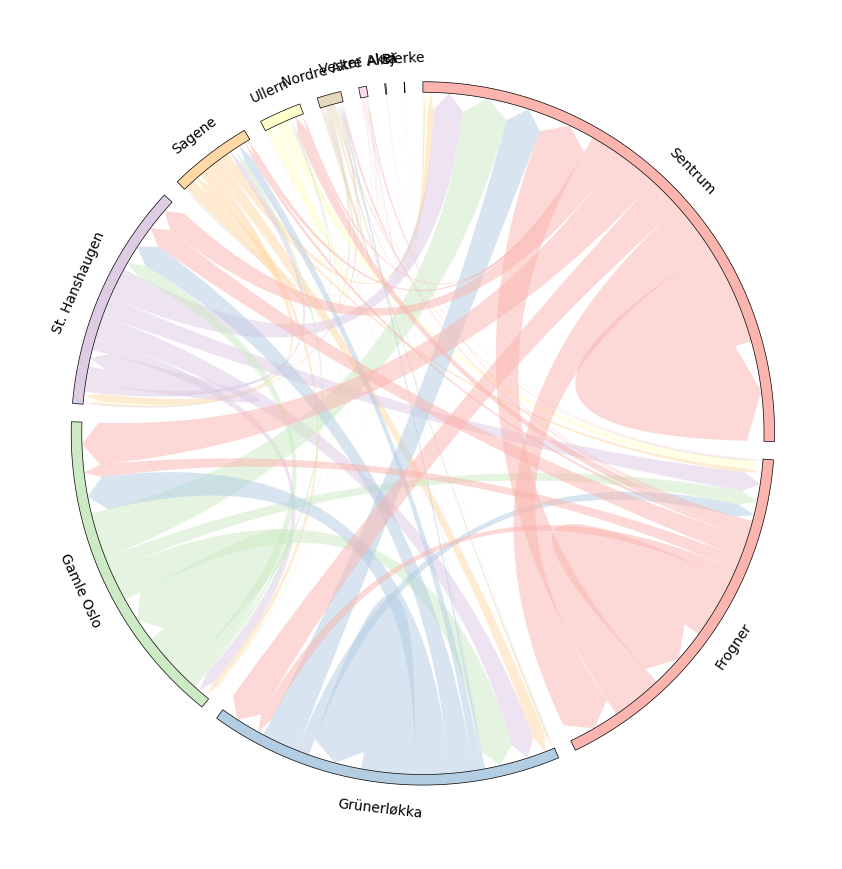

In [56]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

# Concatenate start_district and end_district
districts = pd.concat([gdf_rides['start_district'], gdf_rides['end_district']])

# Get top 5 districts with most rides
top_districts = districts.value_counts()
filtered_gdf_rides = gdf_rides[gdf_rides['start_district'].isin(top_districts.index) & gdf_rides['end_district'].isin(top_districts.index)]

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_district', 'end_district']).size().unstack().fillna(0)
matrix_df = pd.DataFrame(from_to_table, index=top_districts.index, columns=top_districts.index)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="Pastel1",  # Change colormap to 'Pastel1'
    label_kws=dict(size=10, r=105),
    link_kws=dict(direction=1, ec="black", lw=0),
)
fig = circos.plotfig()